# Analyzing Fair PCA on different datasets


### Imports


In [1]:
from sklearn.model_selection import train_test_split
import dython
import numpy as np
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.tree as tree
import seaborn as sns
import pandas as pd

import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap

## Recidivism


In [2]:
df_recidivism = pd.read_csv(f'data/propublica_data_for_fairml.csv')

df_recidivism['Caucasian'] = ((df_recidivism['Other'] == 0) & (df_recidivism['African_American'] == 0) & (
    df_recidivism['Asian'] == 0) & (df_recidivism['Hispanic'] == 0) & (df_recidivism['Native_American'] == 0)).astype(int)
df_recidivism['Between_TwentyFive_And_FourtyFive'] = (
    (df_recidivism['Age_Above_FourtyFive'] == 0) & (df_recidivism['Age_Below_TwentyFive'] == 0)).astype(int)
df_recidivism['Male'] = (df_recidivism['Female'] == 0).astype(int)

# revert one hot encoding
races = ['Other', 'African_American', 'Asian', 'Hispanic', 'Native_American', 'Caucasian']
df_recidivism['Race'] = df_recidivism[races].idxmax(axis=1)
df_recidivism = df_recidivism.drop(races, axis=1)

genders = ['Female', 'Male']
df_recidivism['Gender'] = df_recidivism[genders].idxmax(axis=1)
df_recidivism = df_recidivism.drop(genders, axis=1)

age_group = ['Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'Between_TwentyFive_And_FourtyFive']
df_recidivism['Age_Group'] = df_recidivism[age_group].idxmax(axis=1)
df_recidivism = df_recidivism.drop(age_group, axis=1)

df_recidivism = df_recidivism.drop('score_factor', axis=1)
df_recidivism = df_recidivism[df_recidivism["Race"].isin(["African_American", "Caucasian"])]
df_recidivism = df_recidivism.reset_index(drop=True)


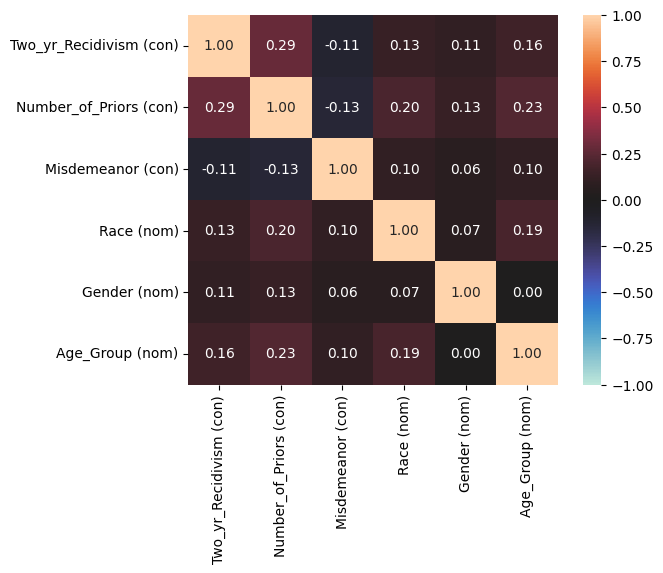

In [3]:
cat_cols = ["Race", "Gender", "Age_Group"]
dython.nominal.associations(df_recidivism, nominal_columns=cat_cols, mark_columns=True);

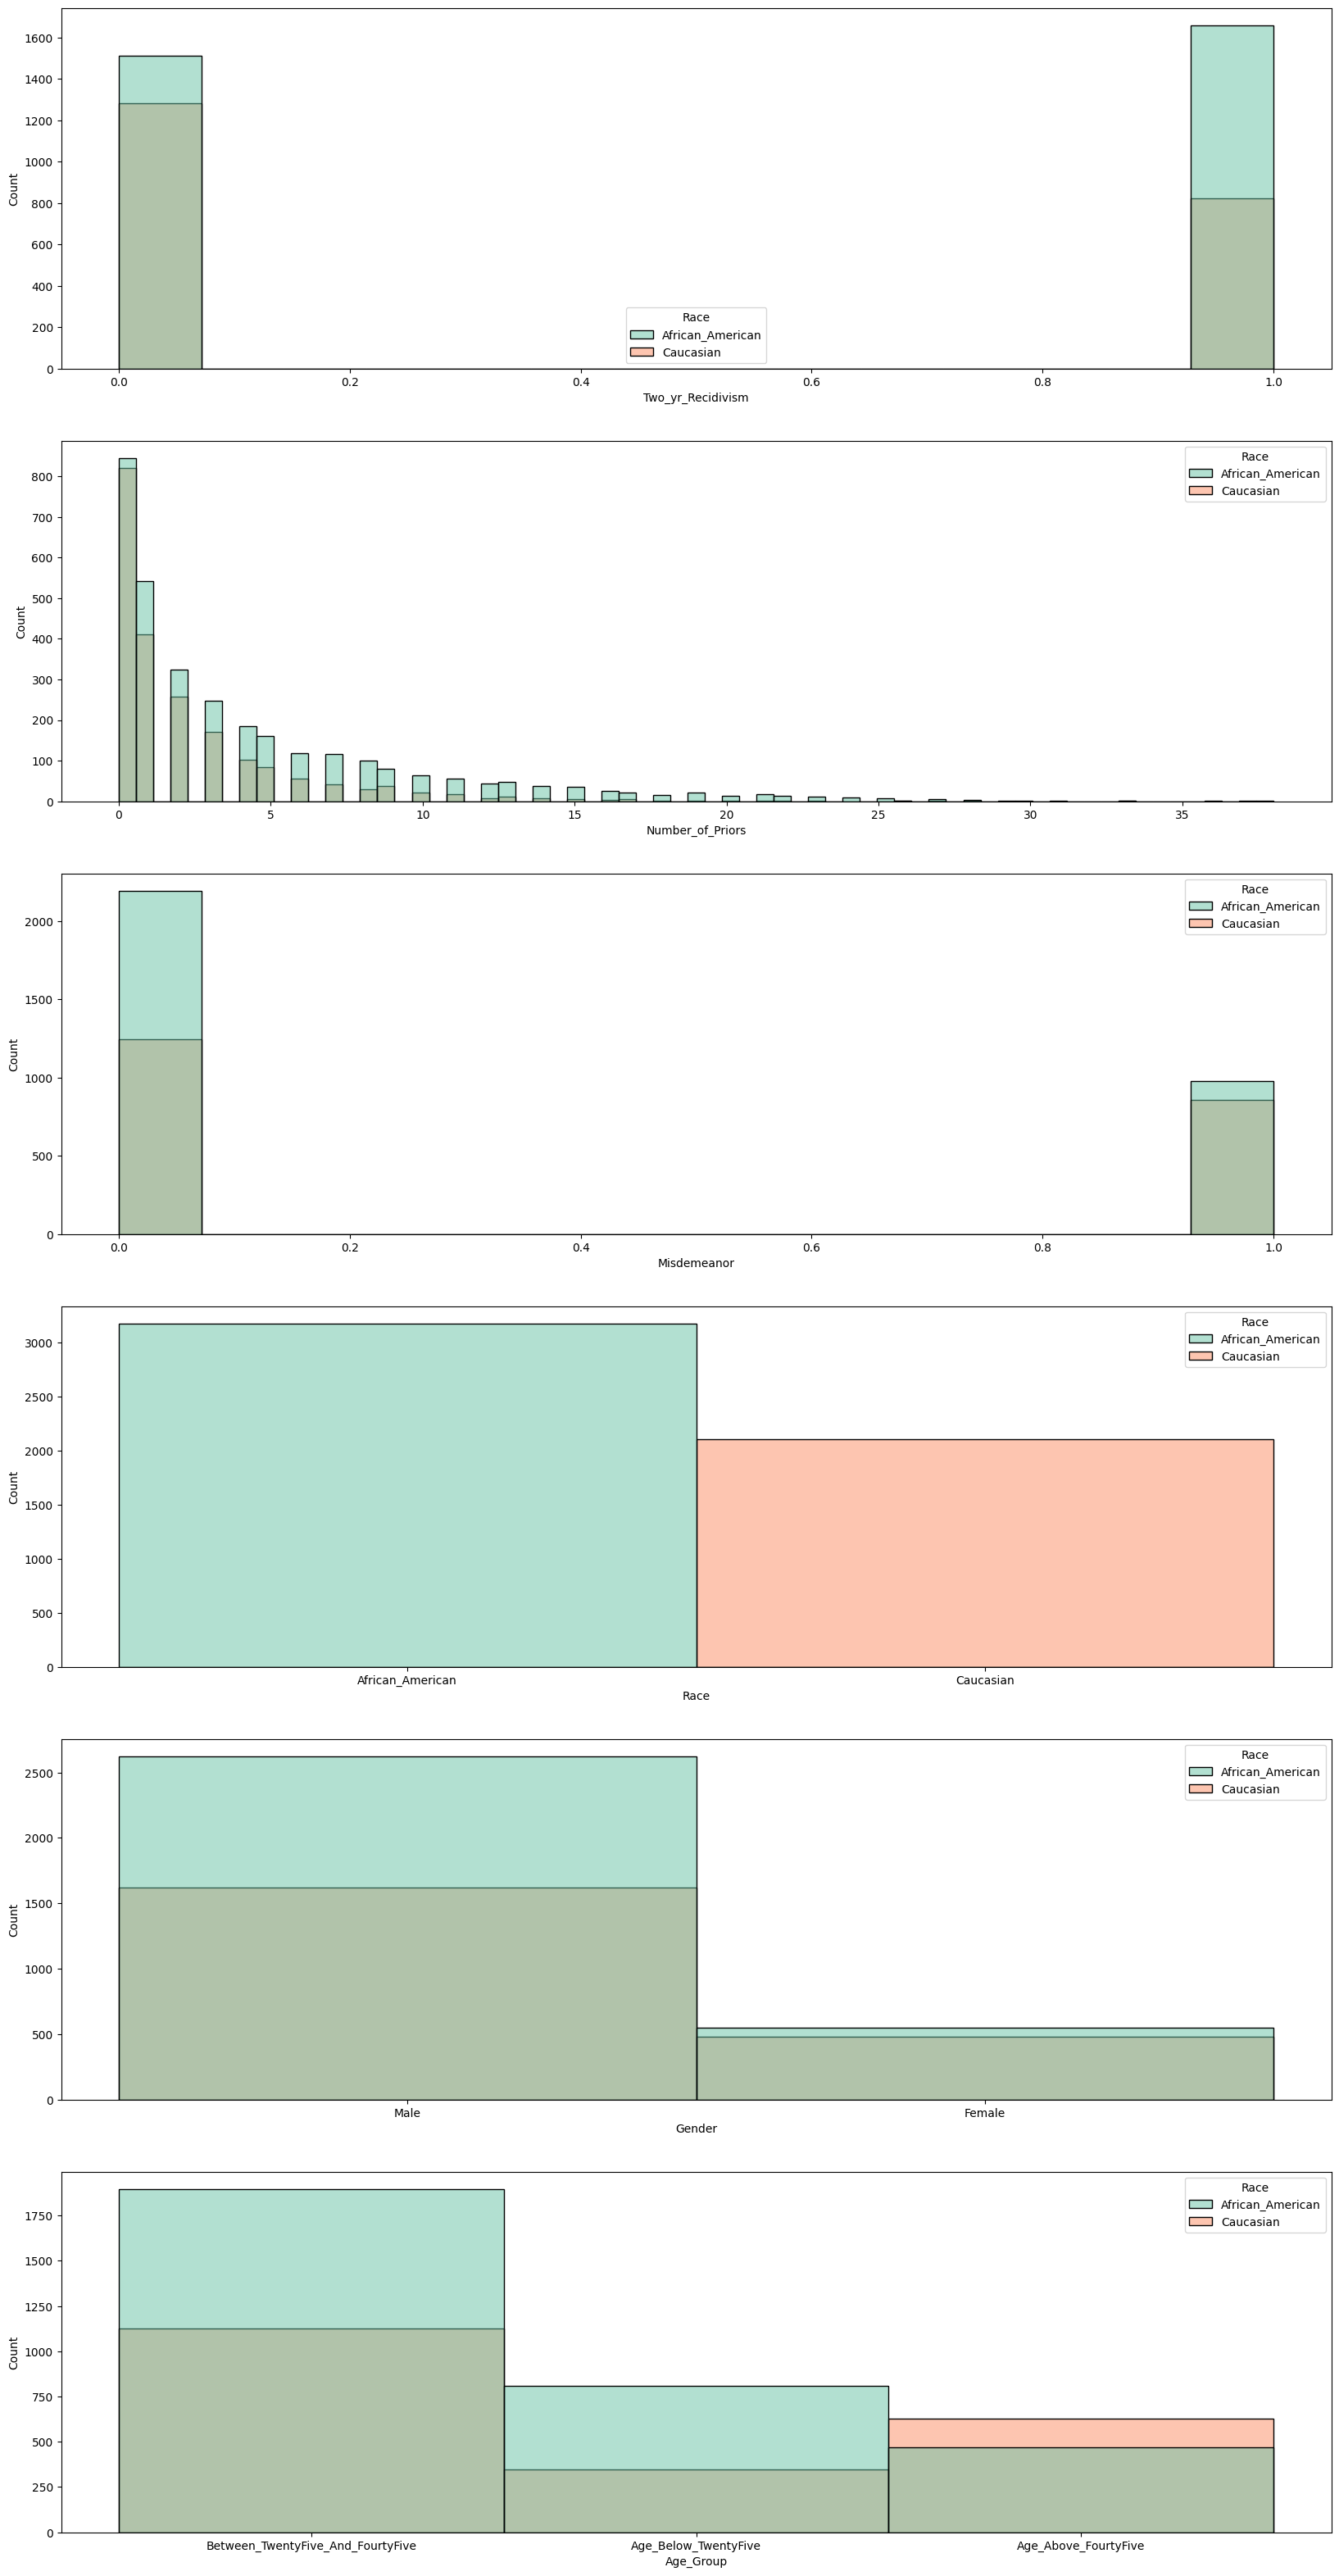

In [4]:
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(len(df_recidivism.columns), figsize=(20, 40))
for i, feature in enumerate(df_recidivism.columns):
    sns.histplot(data=df_recidivism, x=feature, hue='Race', ax=axes[i], palette='Set2')
# plt.show()


In [5]:
# one hot encode data
dummies_df_recividism = pd.get_dummies(df_recidivism, columns=cat_cols, drop_first=True)
# remove target variable from features
labels = dummies_df_recividism.Two_yr_Recidivism
features = dummies_df_recividism.drop("Two_yr_Recidivism", axis=1)

features = features[["Number_of_Priors", "Misdemeanor", "Age_Group_Age_Below_TwentyFive",
                     "Age_Group_Between_TwentyFive_And_FourtyFive", "Race_Caucasian", "Gender_Male"]]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("Race" in f) or ("Gender" in f):
        print("Column ID: %s" % i, "(%s)" % f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)


Column ID: 4 (Race_Caucasian)
Column ID: 5 (Gender_Male)
[4, 5]


In [6]:
# last columns of our data contains the protected features
protected = X_train[:, -2:]
nonprotected = X_train[:, :-2]

protected_test = X_test[:, -2:]
nonprotected_test = X_test[:, :-2]


In [7]:
def calculate_metrics(y_true, y_pred):
    """
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    Returns
    -------
    recall : float
        Recall of the positive class in binary classification or weighted
        average of the recall of each class for the multiclass task.
    precision : float
        Precision of the positive class in binary classification or weighted
        average of the precision of each class for the multiclass task.
    f1_score : float
        F1 score of the positive class in binary classification or weighted
        average of the F1 score of each class for the multiclass task.
    accuracy : float
        Accuracy of the positive class in binary classification or weighted
        average of the accuracy of each class for the multiclass task.
    """

    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (TP/(TP+FN) + TN/(TN+FP)) / 2

    metrics_dict = {'recall': recall,
                    'precision': precision,
                    'f1_score': f1_score,
                    'accuracy': accuracy}
    
    return metrics_dict


In [8]:
# caluclate statistical parity, equalized odds and equalized outcome for all groups
def calculate_fairness_metrics(y_true, y_pred, groups):
    """
    Calculate statistical parity, equalized odds and equalized outcome for all groups
    """
    metrics = {}
    for group in groups:
        group1_idx = np.where(groups[group] == 0)
        group2_idx = np.where(groups[group] == 1)
        y_true_group1 = y_true[group1_idx]
        y_true_group2 = y_true[group2_idx]
        y_pred_group1 = y_pred[group1_idx]
        y_pred_group2 = y_pred[group2_idx]
        tpr_group1 = np.mean(y_pred_group1[y_true_group1 == 1] == 1)
        tpr_group2 = np.mean(y_pred_group2[y_true_group2 == 1] == 1)
        fpr_group1 = np.mean(y_pred_group1[y_true_group1 == 0] == 1)
        fpr_group2 = np.mean(y_pred_group2[y_true_group2 == 0] == 1)
        fnr_group1 = np.mean(y_pred_group1[y_true_group1 == 1] == 0)
        fnr_group2 = np.mean(y_pred_group2[y_true_group2 == 1] == 0)
        tnr_group1 = np.mean(y_pred_group1[y_true_group1 == 0] == 0)
        tnr_group2 = np.mean(y_pred_group2[y_true_group2 == 0] == 0)

        equalized_odds_tpr = np.abs(tpr_group1 - tpr_group2)
        equalized_odds_fpr = np.abs(fpr_group1 - fpr_group2)

        metrics[group] = {}
        metrics[group]['equalized_odds_tpr'] = equalized_odds_tpr
        metrics[group]['equalized_odds_fpr'] = equalized_odds_fpr
        metrics[group]['equalized_odds'] = min(equalized_odds_tpr, equalized_odds_fpr)
        metrics[group][0] = {}
        metrics[group][1] = {}
        metrics[group][0]['tpr'] = tpr_group1
        metrics[group][0]['fpr'] = fpr_group1
        metrics[group][1]['tpr'] = tpr_group2
        metrics[group][1]['fpr'] = fpr_group2
        metrics[group][0]['fnr'] = fnr_group1
        metrics[group][0]['tnr'] = tnr_group1
        metrics[group][1]['fnr'] = fnr_group2
        metrics[group][1]['tnr'] = tnr_group2


    return metrics


def calculate_balanced_accuracy_groups(y_true, y_pred, groups):
    """
    Calculate balanced accuracy for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0, 1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['balanced_accuracy'] = calculate_metrics(
                y_true_group, y_pred_group)['accuracy']
    return metrics

### with XGBoost


In [9]:
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline = Pipeline([('scaler', scaler), ('xgb', xgb)])
xgb_pipeline.fit(nonprotected, y_train)
y_pred_xgb = xgb_pipeline.predict(nonprotected_test)
metric_scores = calculate_metrics(y_test, y_pred_xgb)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6621302003329241
Precision on test set: 0.6409883720930233
Recall on test set: 0.610803324099723
F1 score on test set: 0.625531914893617


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


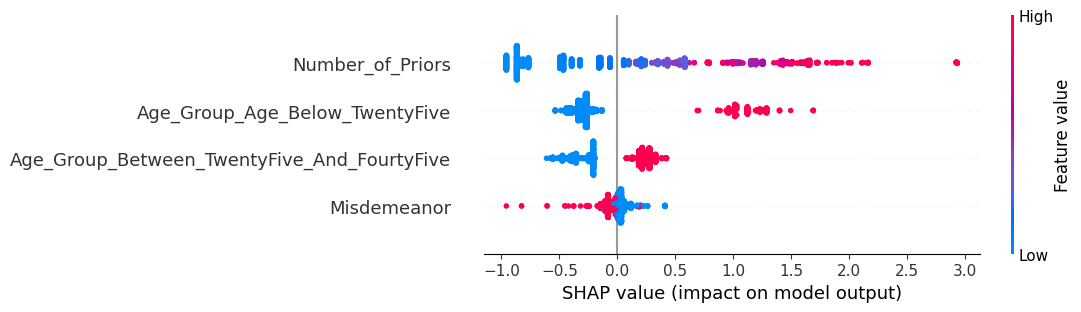

In [10]:
X_train_ = xgb_pipeline['scaler'].transform(nonprotected)
X_test_ = xgb_pipeline['scaler'].transform(nonprotected_test)

# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_pipeline['xgb'], X_train_, feature_names=features.columns[:-2])
shap_values = explainer(X_test_)
shap.plots.beeswarm(shap_values, max_display=10)

In [11]:
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred_xgb, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

Race_Caucasian : {'equalized_odds_tpr': 0.2843773873185638, 'equalized_odds_fpr': 0.14358645012409108, 'equalized_odds': 0.14358645012409108, 0: {'tpr': 0.7045454545454546, 'fpr': 0.35084033613445376, 'fnr': 0.29545454545454547, 'tnr': 0.6491596638655462}, 1: {'tpr': 0.42016806722689076, 'fpr': 0.20725388601036268, 'fnr': 0.5798319327731093, 'tnr': 0.7927461139896373}}
Gender_Male : {'equalized_odds_tpr': 0.18745334364862848, 'equalized_odds_fpr': 0.13362085186774147, 'equalized_odds': 0.13362085186774147, 0: {'tpr': 0.45528455284552843, 'fpr': 0.18407960199004975, 'fnr': 0.5447154471544715, 'tnr': 0.8159203980099502}, 1: {'tpr': 0.6427378964941569, 'fpr': 0.3177004538577912, 'fnr': 0.3572621035058431, 'tnr': 0.6822995461422088}}


In [23]:
# get elements from y_test and y_pred_xgb that are in group_test['Gender_Male'] == 0
idx_female = np.where(group_test["Gender_Male"] == 0)
idx_male = np.where(group_test["Gender_Male"] == 1)
idx_white = np.where(group_test["Race_Caucasian"] == 1)
idx_black = np.where(group_test["Race_Caucasian"] == 0)
y_pred_female = y_pred_xgb[idx_female]
y_test_female = y_test[idx_female]

y_pred_male = y_pred_xgb[idx_male]
y_test_male = y_test[idx_male]

y_pred_white = y_pred_xgb[idx_white]
y_test_white = y_test[idx_white]

y_pred_black = y_pred_xgb[idx_black]
y_test_black = y_test[idx_black]

In [25]:
import fairlearn.metrics as flm
equalized_odds_race = flm.equalized_odds_ratio(y_test, y_pred_xgb, sensitive_features=group_test["Race_Caucasian"])
equalized_odds_gender = flm.equalized_odds_ratio(y_test, y_pred_xgb, sensitive_features=group_test["Gender_Male"])

tpr_male = flm.true_positive_rate(y_test_male, y_pred_male)
tpr_female = flm.true_positive_rate(y_test_female, y_pred_female)
tpr_white = flm.true_positive_rate(y_test_white, y_pred_white)
tpr_black = flm.true_positive_rate(y_test_black, y_pred_black)

In [26]:
print(equalized_odds_race)
print(equalized_odds_gender)

print(tpr_white)
print(tpr_black)

print(tpr_male)
print(tpr_female)

0.5907356271912134
0.5794124615020138
0.42016806722689076
0.7045454545454546
0.6427378964941569
0.45528455284552843


In [22]:
# calculate uncertainty by bootstrapping
def calc_certainty(y_test, y_pred):
    n_bootstraps = 1000
    bootstrapped_scores = []
    interval = 0.95
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue

        score = calculate_metrics(y_test[indices], y_pred[indices])['f1_score']
        bootstrapped_scores.append(score)

    print(f"Confidence interval for the f1_score [{interval}]:" + "[{:0.3f} - {:0.3}]".format(
        np.percentile(bootstrapped_scores, ((1-interval)/2)*100),
        np.percentile(bootstrapped_scores, (interval + (1-interval)/2)*100)))

In [23]:
calc_certainty(y_test, y_pred_xgb)

Confidence interval for the f1_score [0.95]:[0.595 - 0.653]


### Fair PCA


In [24]:
# apply unfair PCA
def unfair_pca(pca, non_protected_features_scaled):

    X_pca = pca.fit_transform(non_protected_features_scaled)

    # pca.explained_variance_ratio_
    # scree plot bar plot
    plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_*100)
    for i in range(len(pca.explained_variance_ratio_)):
        plt.text(i+0.7, pca.explained_variance_ratio_[i]*100+0.3, str(round(pca.explained_variance_ratio_[i]*100,2))+'%')
    plt.xlabel('Principal Component')
    plt.show()

    return X_pca

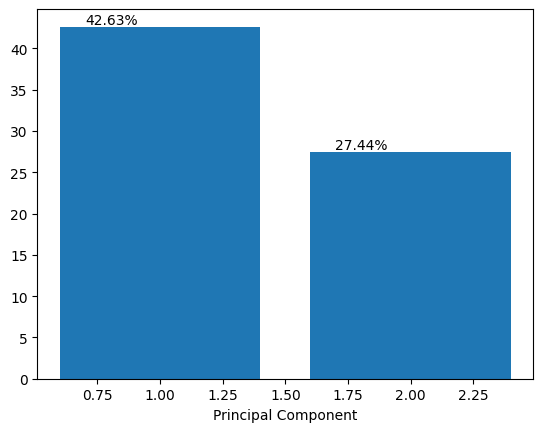

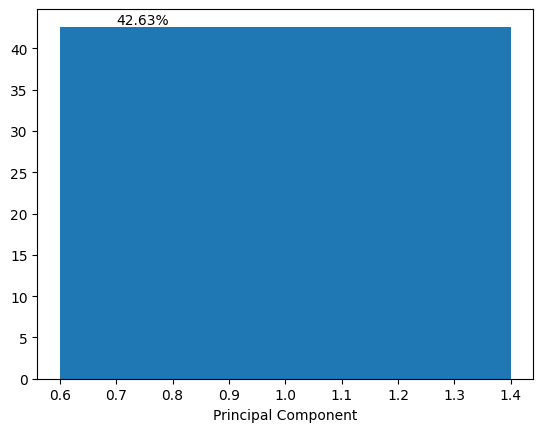

In [25]:
pca_2 = PCA(n_components=(len(features.columns)-4)) # - protected features
pca_1 = PCA(n_components=1)
scaler = StandardScaler()

# normalize column for number of priors, the others are one hot encoded
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(non_protected_features_scaled)

X_pca_2 = unfair_pca(pca_2, non_protected_features_scaled)
X_pca_1 = unfair_pca(pca_1, non_protected_features_scaled)

In [26]:
def plot_pca_corr(X_pca, protected, groups, figsize=(24, 3)):

    df = pd.DataFrame(np.concatenate((protected, X_pca), axis=1))
    corr = df.corr()
    
    pc_list = ["PC" + str(i) for i in range(1, X_pca.shape[1]+1)]
    corr.columns = groups + pc_list

    rows_to_plot = [x for x in corr.columns if "PC" in x]
    indices_to_plot = range(len(groups))
    corr = corr.loc[indices_to_plot, rows_to_plot]
    indices = groups
    corr.index = indices
    plt.figure(figsize=figsize)
    sns.heatmap(corr,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.5,
                vmin=-0.2,
                vmax=0.2,
                fmt='.2f');
    plt.show()

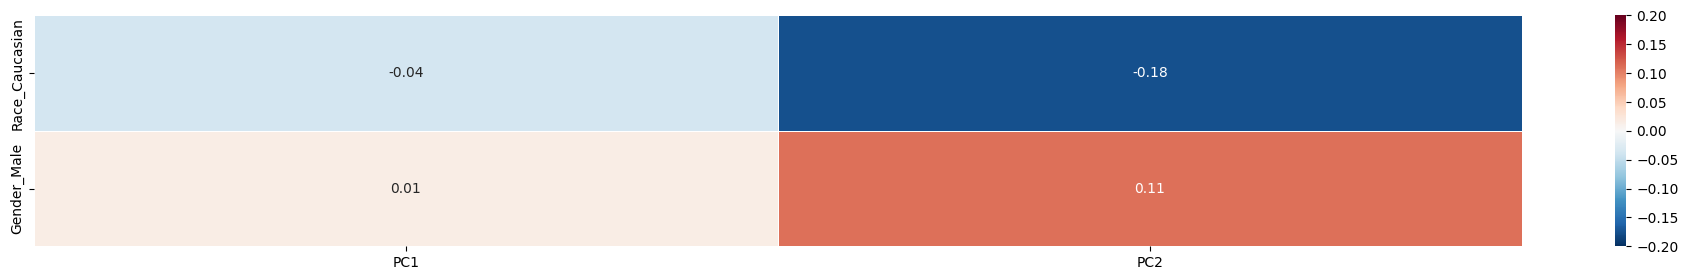

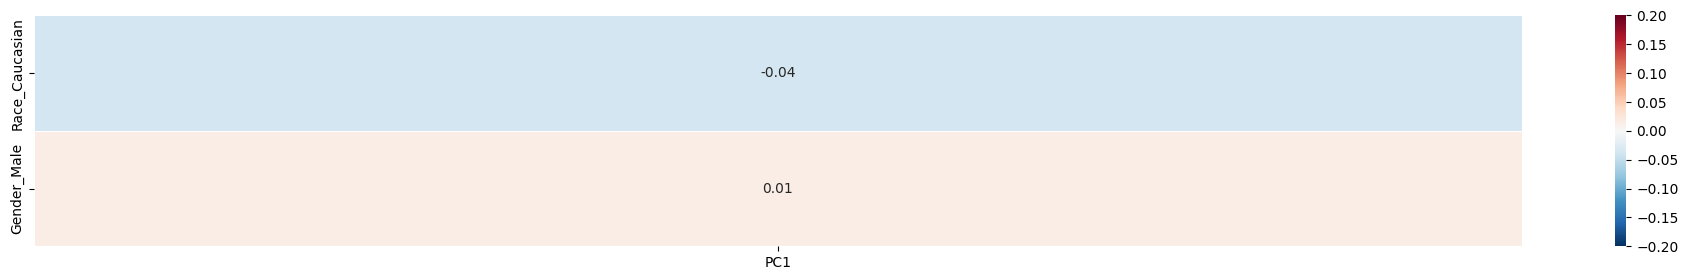

In [27]:
plot_pca_corr(X_pca_2, protected, list(groups.columns))
plot_pca_corr(X_pca_1, protected, list(groups.columns))

In [28]:
def reconstruction_error(X_pca_test, pca, non_protected_features_scaled_test, protected):
    # project test data with pca
    X_pca_test = pca.transform(non_protected_features_scaled_test)

    # project it back into the original space
    X_reconstructed_test = pca.inverse_transform(X_pca_test)

    # calculate reconstruction error for each sample as mean absolute error
    reconstruction_error_test = []
    for i in range(len(non_protected_features_scaled_test)):
        reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))

    # get reconstruction error for protected features
    female_error = []
    male_error = []
    whites_error = []
    african_american_error = []
    for i in range(len(reconstruction_error_test)):

        # 1 is white and 0 is african american
        if protected[i][0] == 1:
            whites_error.append(reconstruction_error_test[i])
        else:
            african_american_error.append(reconstruction_error_test[i])
            
        # 1 is male and 0 is female
        if protected[i][1] == 1:
            male_error.append(reconstruction_error_test[i])
        else:
            female_error.append(reconstruction_error_test[i])

    # calculate mean reconstruction error for each group
    print(np.mean(male_error))
    print(np.mean(female_error))
    print(np.mean(whites_error))
    print(np.mean(african_american_error))


In [29]:
# normalize column for number of priores
non_protected_features_scaled_test = nonprotected_test.copy()
non_protected_features_scaled_test = scaler.transform(non_protected_features_scaled_test)

reconstruction_error(X_pca_2, pca_2, non_protected_features_scaled_test, protected_test)
print("------------------")
reconstruction_error(X_pca_1, pca_1, non_protected_features_scaled_test, protected_test)

0.42041427366919665
0.38672757878830505
0.4292082712004043
0.40332891575161084
------------------
0.5977353859247486
0.5752131932195529
0.6043618091246084
0.5858269708068362


In [30]:
# apply fair PCA
import scipy

def fair_pca(non_protected_features_scaled, protected, n_components):
    X = non_protected_features_scaled.copy()
    # create Matrix Z with protected features
    Z = protected.copy()
    # remove mean from each column
    Z = Z - np.mean(Z, axis=0)
    # find orthonormal null space spanned by ZTX with scipy.linalg.null_space
    R = scipy.linalg.null_space(Z.T @ X)

    # Find orthonormal eigenvectors RTXTXR with scipy.linalg.eig
    eigvals, eigvecs = scipy.linalg.eig((R.T @ X.T) @ (X @ R))
    # sort eigenvectors by eigenvalues
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # get matrix of first n eigenvectors
    L = eigvecs[:,:n_components]

    # projection matrix U = RL
    U = R @ L

    # project data
    X_projected = X @ U

    return X_projected, Z, U


In [31]:
X_projected_2, Z_2, U_2 = fair_pca(non_protected_features_scaled, protected, 2)
X_projected_1, Z_1, U_1 = fair_pca(non_protected_features_scaled, protected, 1)

In [32]:
features.columns[:-2]

Index(['Number_of_Priors', 'Misdemeanor', 'Age_Group_Age_Below_TwentyFive',
       'Age_Group_Between_TwentyFive_And_FourtyFive'],
      dtype='object')

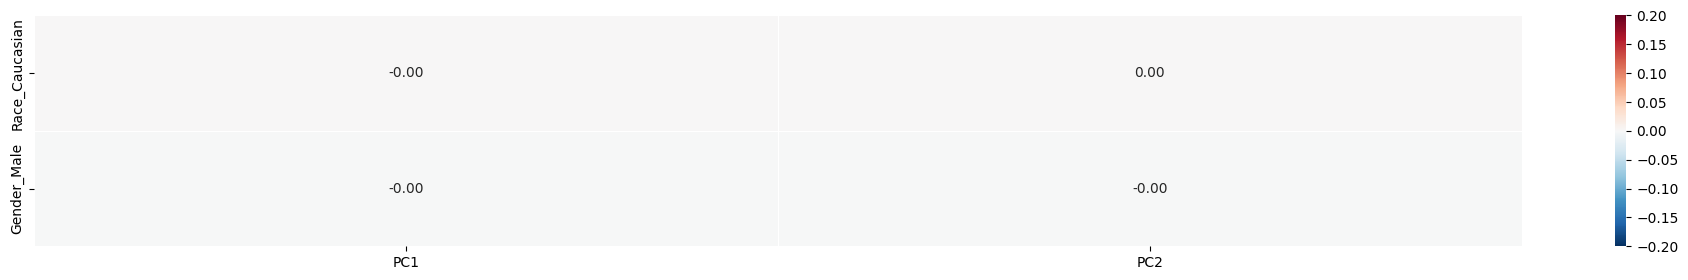

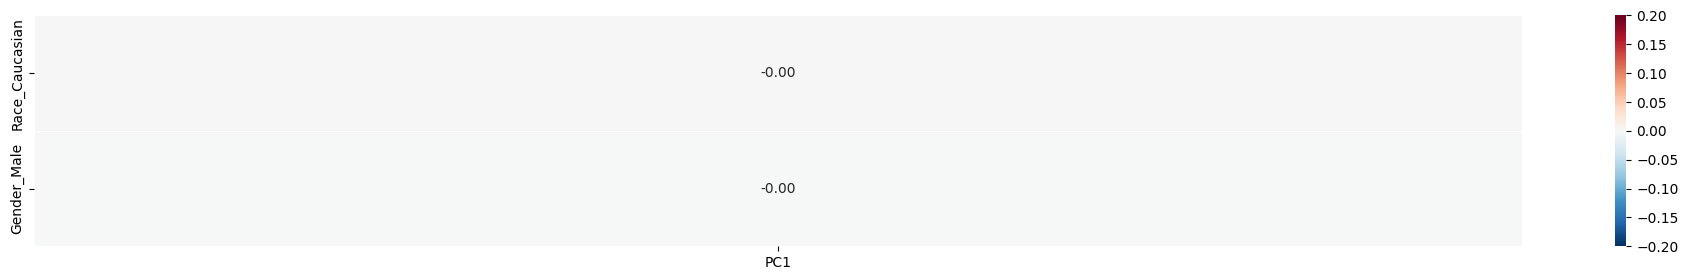

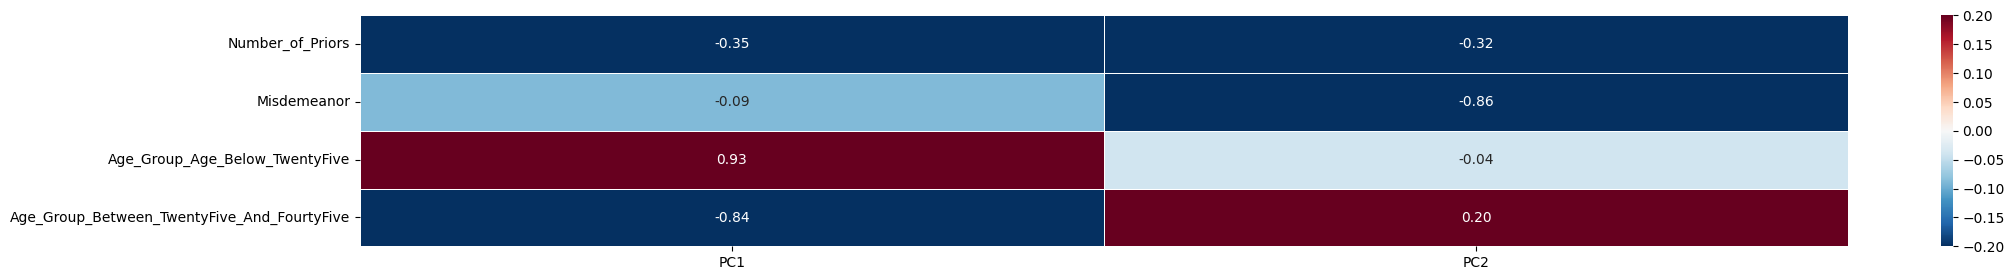

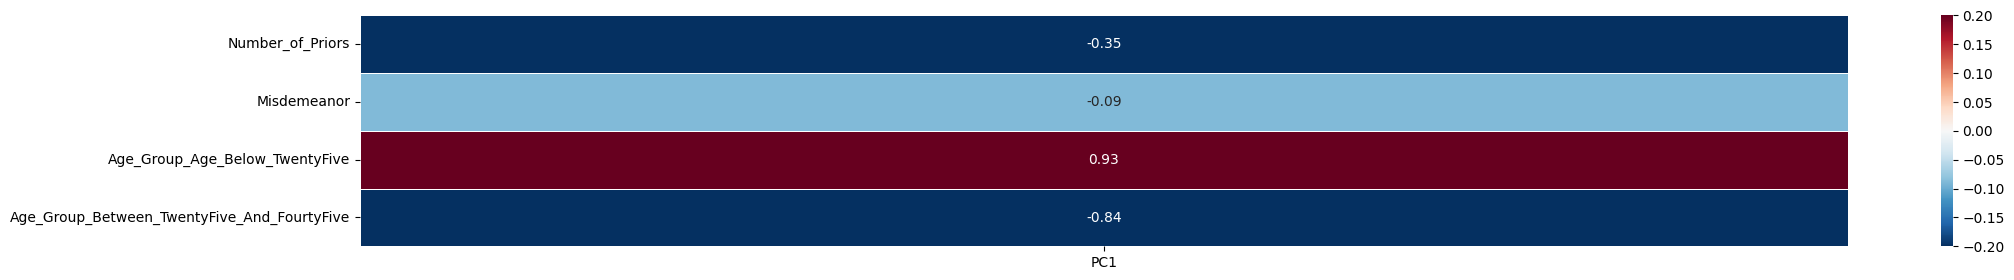

In [33]:
plot_pca_corr(X_projected_2, protected, list(groups.columns))
plot_pca_corr(X_projected_1, protected, list(groups.columns))
plot_pca_corr(X_projected_2, nonprotected, list(features.columns[:-2]))
plot_pca_corr(X_projected_1, nonprotected, list(features.columns[:-2]))

In [34]:
def reconstruction_error_fair_pca(X_projected, X_test_projected, U, non_protected_features_scaled_test, protected):

    # reproject it back into the original space
    X_reconstructed = X_projected @ U.T
    X_reconstructed_test = X_test_projected @ U.T

    # calculate reconstruction error for each sample as mean absolute error
    reconstruction_error = []
    for i in range(len(non_protected_features_scaled)):
        reconstruction_error.append(np.mean(np.abs(non_protected_features_scaled[i] - X_reconstructed[i])))
    reconstruction_error_test = []
    for i in range(len(non_protected_features_scaled_test)):
        reconstruction_error_test.append(np.mean(np.abs(non_protected_features_scaled_test[i] - X_reconstructed_test[i])))
    # get reconstruction error for protected features
    female_error = []
    male_error = []
    whites_error = []
    african_american_error = []
    for i in range(len(reconstruction_error_test)):

        # 1 is white and 0 is african american
        if protected[i][0] == 1:
            whites_error.append(reconstruction_error_test[i])
        else:
            african_american_error.append(reconstruction_error_test[i])
            
        # 1 is male and 0 is female
        if protected[i][1] == 1:
            male_error.append(reconstruction_error_test[i])
        else:
            female_error.append(reconstruction_error_test[i])

    # calculate mean reconstruction error for each group
    print(np.mean(male_error))
    print(np.mean(female_error))
    print(np.mean(whites_error))
    print(np.mean(african_american_error))

In [35]:
# project test data
X_test_projected_2 = non_protected_features_scaled_test @ U_2
X_test_projected_1 = non_protected_features_scaled_test @ U_1

reconstruction_error_fair_pca(X_projected_2, X_test_projected_2, U_2, non_protected_features_scaled_test, protected_test)
print("------------------")
reconstruction_error_fair_pca(X_projected_1, X_test_projected_1, U_1, non_protected_features_scaled_test, protected_test)

0.4418465371499373
0.40171094070537233
0.43623119095142227
0.43195074837893155
------------------
0.5817429877402873
0.5607276603979475
0.6038596493561891
0.5602744847119115


In [36]:
xgb_2 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_2 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0,None))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_2 = Pipeline([('scaler', scaler_2), ('xgb', xgb_2)])
xgb_pipeline_2.fit(X_projected_2, y_train)
y_pred_xgb_2 = xgb_pipeline_2.predict(X_test_projected_2)
metric_scores = calculate_metrics(y_test, y_pred_xgb_2)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6616803028452802
Precision on test set: 0.6426470588235295
Recall on test set: 0.6052631578947368
F1 score on test set: 0.62339514978602


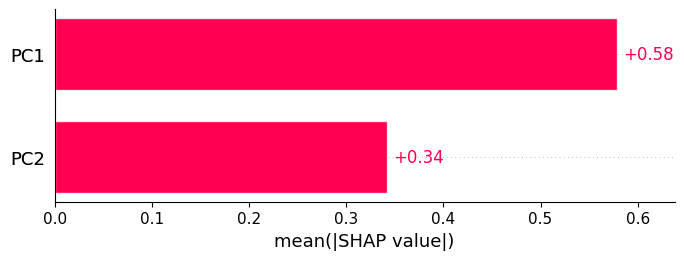

In [37]:
X_train_2 = xgb_pipeline_2['scaler'].transform(X_projected_2)
X_test_2 = xgb_pipeline_2['scaler'].transform(X_test_projected_2)

# explain the model's predictions using SHAP
explainer_2 = shap.Explainer(xgb_pipeline_2['xgb'], X_train_2, feature_names=[f"PC{i}" for i in range(1,len(X_train_2[0])+1)])
shap_values_2 = explainer_2(X_test_2)
shap.plots.bar(shap_values_2, max_display=10)

In [38]:
#
xgb_1 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_1 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0,None))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_1 = Pipeline([('scaler', scaler_1), ('xgb', xgb_1)])
xgb_pipeline_1.fit(X_projected_1, y_train)
y_pred_xgb_1 = xgb_pipeline_1.predict(X_test_projected_1)
metric_scores = calculate_metrics(y_test, y_pred_xgb_1)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6651252321792391
Precision on test set: 0.6422413793103449
Recall on test set: 0.6191135734072022
F1 score on test set: 0.6304654442877293


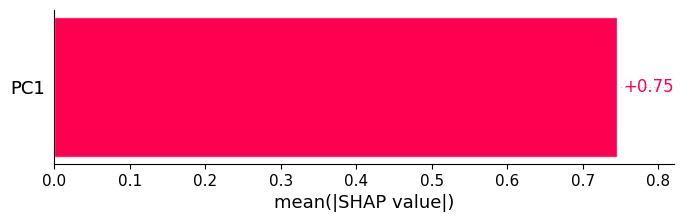

In [39]:
X_train_1 = xgb_pipeline_1['scaler'].transform(X_projected_1)
X_test_1 = xgb_pipeline_1['scaler'].transform(X_test_projected_1)

# explain the model's predictions using SHAP
explainer_1 = shap.Explainer(xgb_pipeline_1['xgb'], X_train_1, feature_names=[f"PC{i}" for i in range(1,len(X_train_1[0])+1)])
shap_values_1 = explainer_1(X_test_1)
shap.plots.bar(shap_values_1, max_display=10)

In [40]:
equalized_odds_gender = flm.equalized_odds_ratio(y_test, y_pred_xgb_2, sensitive_features=group_test["Gender_Male"])
equalized_odds_race = flm.equalized_odds_ratio(y_test, y_pred_xgb_2, sensitive_features=group_test["Race_Caucasian"])

In [42]:
print(equalized_odds_gender)
print(equalized_odds_race)

0.5906631889098198
0.5940224946290914


In [30]:
# calculate fairness metrics and accuracy scores
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred_xgb_2, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

Race_Caucasian : {'equalized_odds_tpr': 0.2761129245086464, 'equalized_odds_fpr': 0.13987460269081725, 'equalized_odds': 0.13987460269081725, 0: {'tpr': 0.6962809917355371, 'fpr': 0.3445378151260504, 'fnr': 0.3037190082644628, 'tnr': 0.6554621848739496}, 1: {'tpr': 0.42016806722689076, 'fpr': 0.20466321243523317, 'fnr': 0.5798319327731093, 'tnr': 0.7953367875647669}}
Gender_Male : {'equalized_odds_tpr': 0.20037460808664848, 'equalized_odds_fpr': 0.1275694146514026, 'equalized_odds': 0.1275694146514026, 0: {'tpr': 0.43902439024390244, 'fpr': 0.18407960199004975, 'fnr': 0.5609756097560976, 'tnr': 0.8159203980099502}, 1: {'tpr': 0.6393989983305509, 'fpr': 0.31164901664145234, 'fnr': 0.3606010016694491, 'tnr': 0.6883509833585476}}


In [43]:
calc_certainty(y_test, y_pred_xgb_2)

Confidence interval for the f1_score [0.95]:[0.592 - 0.652]


## Wage Equality


In [44]:
# Dataset from https://www.princeton.edu/~mwatson/Stock-Watson_3u/Students/Stock-Watson-EmpiricalExercises-DataSets.htm
# Prottected attribute is 'female'. Target is 'eanwke'

# All values are int or float already
df_weekly_earn = pd.read_csv('data/employment.csv')

# Drop 600 rows of the total 5000 rows, which have nan values
df_weekly_earn = df_weekly_earn.dropna()
df_weekly_earn = df_weekly_earn[df_weekly_earn["race"] != 3] # drop other race
df_weekly_earn['race'] = df_weekly_earn['race'] - 1 # 0 is white, 1 is african american
df_weekly_earn = df_weekly_earn.drop(['self', 'private'], axis=1) # drop self employed, private employed cause opposite of "government" column

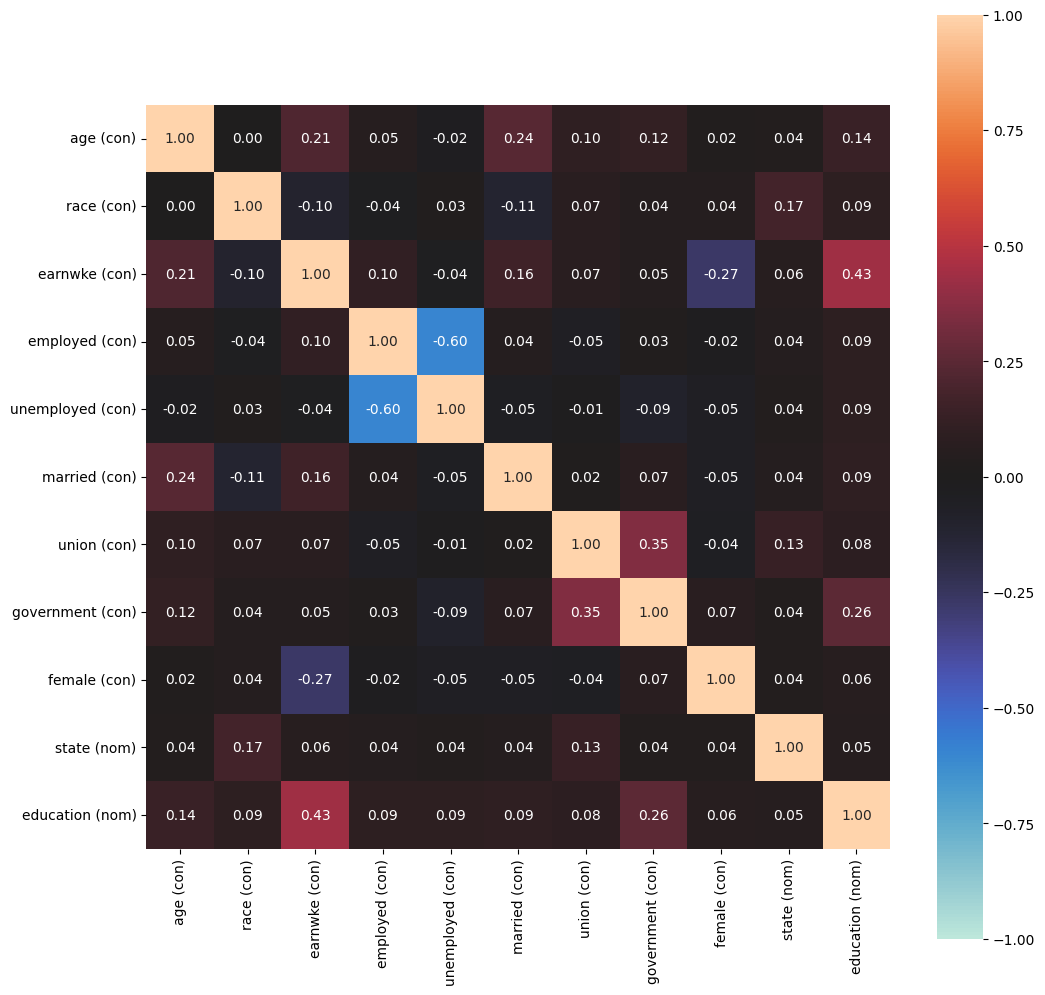

In [45]:
df_weekly_no_dummies = df_weekly_earn.copy()
# create a new 'state' column by using the column names to map to the desired values
df_weekly_no_dummies['state'] = df_weekly_no_dummies.apply(lambda row: 'ne' if row['ne_states'] == 1 else ('so' if row['so_states'] == 1 else ('ce' if row['ce_states'] == 1 else 'we')), axis=1)

# drop the original one-hot encoded columns
df_weekly_no_dummies = df_weekly_no_dummies.drop(['ne_states', 'so_states', 'ce_states', 'we_states'], axis=1)

# create a new 'education' column by using the column names to map to the desired values
df_weekly_no_dummies['education'] = df_weekly_no_dummies.apply(lambda row: "less than high school" if row['educ_lths'] == 1 else ("high school" if row['educ_hs'] == 1 else ("some college" if row['educ_somecol'] == 1 else ("associate's degree" if row['educ_aa'] == 1 else ("bachelor's degree" if row['educ_bac'] == 1 else "advanced degree")))), axis=1)

# drop the original one-hot encoded columns
df_weekly_no_dummies = df_weekly_no_dummies.drop(['educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv'], axis=1)

# get list of categorical columns
num_cols = df_weekly_no_dummies._get_numeric_data().columns
cat_cols = list(set(df_weekly_no_dummies.columns) - set(num_cols))


dython.nominal.associations(
    df_weekly_no_dummies, nominal_columns=cat_cols, mark_columns=True, figsize=(12, 12));

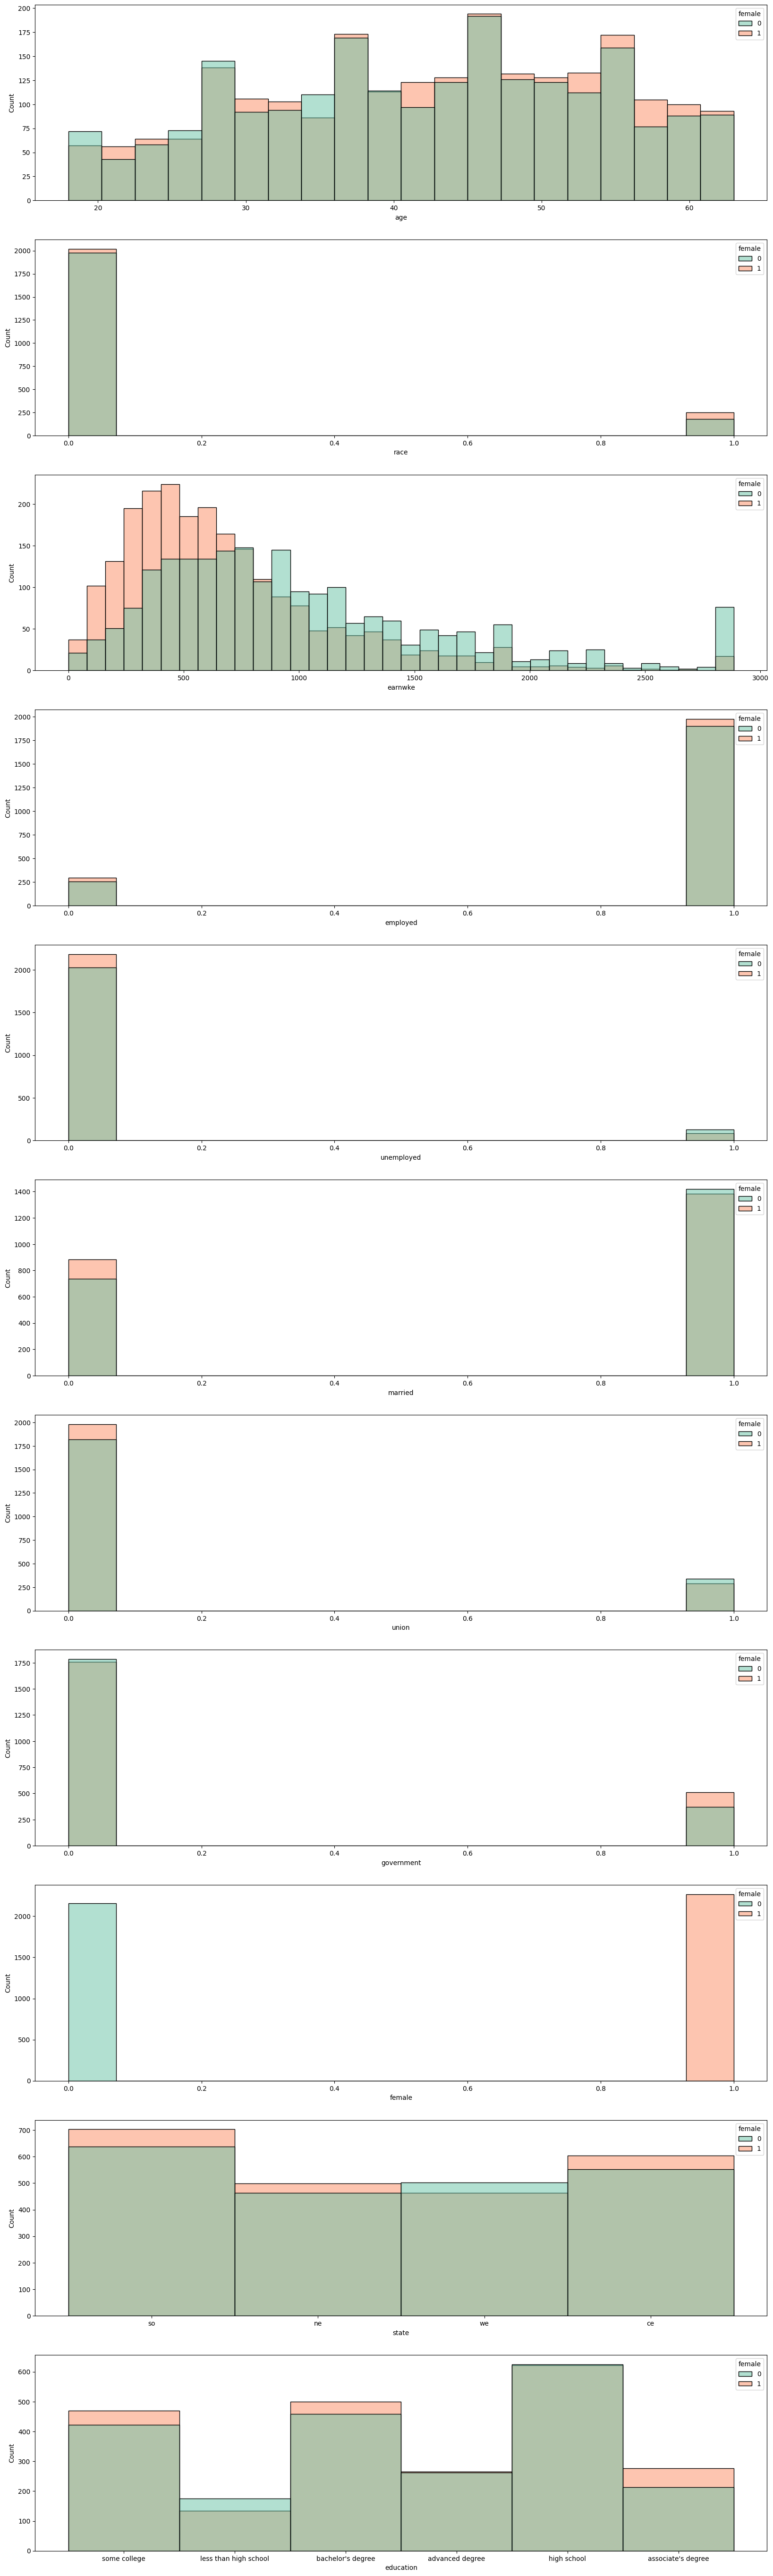

In [46]:
fig, axes = plt.subplots(len(df_weekly_no_dummies.columns), figsize=(20, 70))
for i, feature in enumerate(df_weekly_no_dummies.columns):
    sns.histplot(data=df_weekly_no_dummies, x=feature, hue='female', ax=axes[i], palette='Set2')
plt.show()

In [47]:
median = df_weekly_earn['earnwke'].median()
df_weekly_earn['earnwke'] = (df_weekly_earn['earnwke'] >= median).astype(int)

In [48]:
# remove target variable from features
labels = df_weekly_earn.earnwke
features = df_weekly_earn.drop("earnwke", axis=1)

# reorder so cloumns with "Gender" or "age" in them are at the end
cols = list(features.columns)
protected_cols = []
for i, col in enumerate(cols):
    if ("race" in col) or ("female" in col):
        protected_cols.append(col)

cols = list(set(cols) - set(protected_cols))

cols = cols + protected_cols
features = features[cols]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("race" in f) or ("female" in f):
        print("Column ID: %s" % i, "(%s)" % f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)


Column ID: 16 (race)
Column ID: 17 (female)
[16, 17]


In [49]:
# last columns of our data contains the protected features
prot_groups = len(indices)
protected = X_train[:, -prot_groups:]
nonprotected = X_train[:, :-prot_groups]

protected_test = X_test[:, -prot_groups:]
nonprotected_test = X_test[:, :-prot_groups]

In [50]:
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline = Pipeline([('scaler', scaler), ('xgb', xgb)])
xgb_pipeline.fit(nonprotected, y_train)
y_pred_xgb = xgb_pipeline.predict(nonprotected_test)
metric_scores = calculate_metrics(y_test, y_pred_xgb)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

Balanced accuracy on test set: 0.6692733146398788
Precision on test set: 0.6661514683153014
Recall on test set: 0.6590214067278287
F1 score on test set: 0.6625672559569561


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


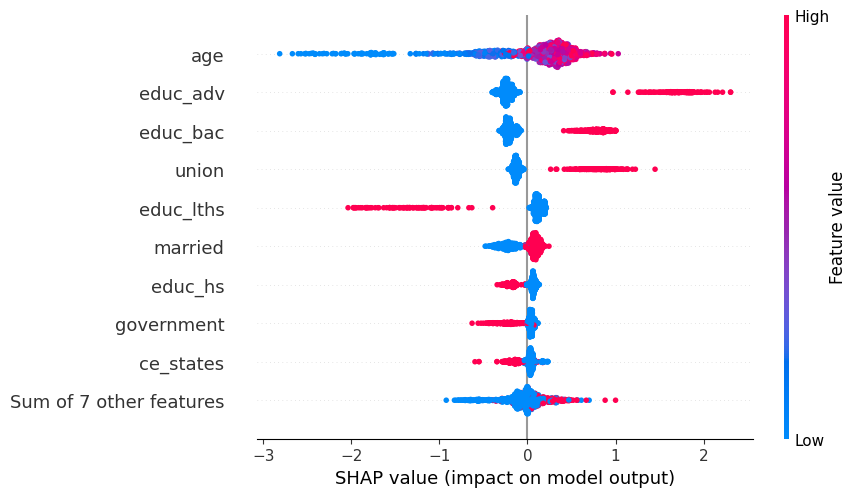

In [51]:
X_train_ = xgb_pipeline['scaler'].transform(nonprotected)
X_test_ = xgb_pipeline['scaler'].transform(nonprotected_test)

# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_pipeline['xgb'], X_train_, feature_names=features.columns[:-2])
shap_values = explainer(X_test_)
shap.plots.beeswarm(shap_values, max_display=10)

In [53]:
group_test

,race,female
267,0,0
1657,0,0
4224,1,0
3566,0,0
1046,0,0
...,...,...
1582,0,0
986,0,1
2166,0,0
4725,1,1


In [70]:
equalized_odds_race = flm.demographic_parity_ratio(y_test, y_pred_xgb, sensitive_features=group_test["race"])
equalized_odds_gender = flm.demographic_parity_ratio(y_test, y_pred_xgb, sensitive_features=group_test["female"])

In [71]:
print(equalized_odds_race)
print(equalized_odds_gender)

0.7509213936078318
0.9235671925702138


In [52]:
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics = calculate_fairness_metrics(y_test, y_pred_xgb, group_test)
for key, value in fairness_metrics.items():
    print(key, ":",  value)

race : {'equalized_odds_tpr': 0.1255858776118095, 'equalized_odds_fpr': 0.028953708483909824, 'equalized_odds': 0.028953708483909824, 0: {'tpr': 0.6661264181523501, 'fpr': 0.3238255033557047, 'fnr': 0.3338735818476499, 'tnr': 0.6761744966442953}, 1: {'tpr': 0.5405405405405406, 'fpr': 0.2948717948717949, 'fnr': 0.4594594594594595, 'tnr': 0.7051282051282052}}
female : {'equalized_odds_tpr': 0.010049398732598136, 'equalized_odds_fpr': 0.09761723217689666, 'equalized_odds': 0.010049398732598136, 0: {'tpr': 0.6552567237163814, 'fpr': 0.2581967213114754, 'fnr': 0.34474327628361856, 'tnr': 0.7418032786885246}, 1: {'tpr': 0.6653061224489796, 'fpr': 0.3558139534883721, 'fnr': 0.3346938775510204, 'tnr': 0.6441860465116279}}


In [41]:
calc_certainty(y_test, y_pred_xgb)

Confidence interval for the f1_score [0.95]:[0.633 - 0.691]


### Fair PCA


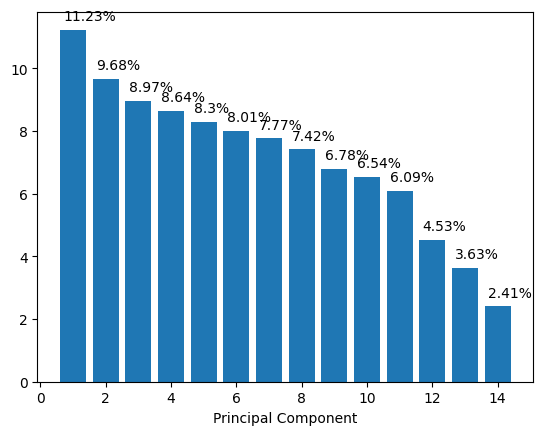

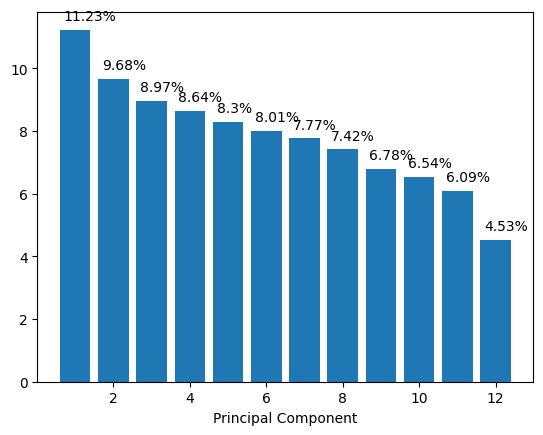

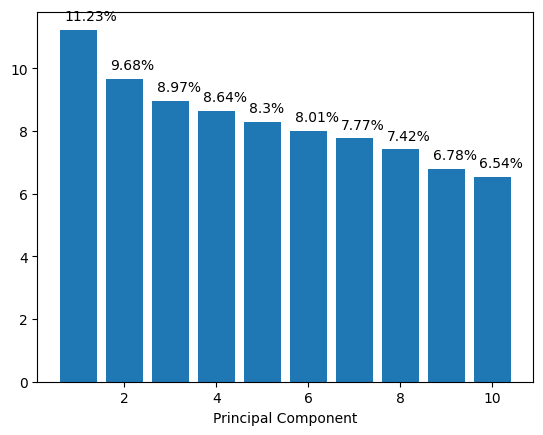

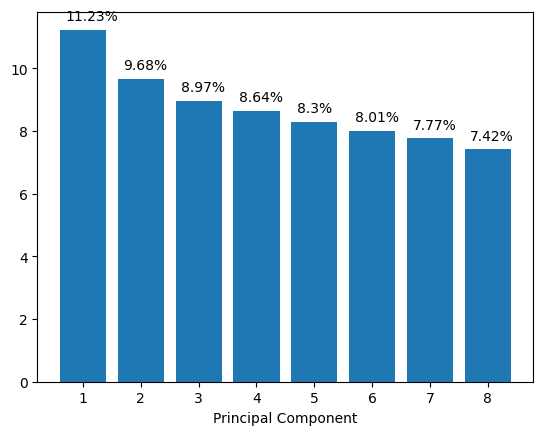

In [56]:
pca_14 = PCA(n_components=(len(features.columns)-4)) # - protected features
pca_12 = PCA(n_components=(len(features.columns)-6)) # trying different amounts of PCs
pca_10 = PCA(n_components=(len(features.columns)-8)) # trying different amounts of PCs
pca_8 = PCA(n_components=(len(features.columns)-10)) # trying different amounts of PCs
scaler = StandardScaler()
# normalize column for number of priors, the others are one hot encoded
non_protected_features_scaled = nonprotected.copy()
non_protected_features_scaled = scaler.fit_transform(non_protected_features_scaled)

X_pca_14 = unfair_pca(pca_14, non_protected_features_scaled)
X_pca_12 = unfair_pca(pca_12, non_protected_features_scaled)
X_pca_10 = unfair_pca(pca_10, non_protected_features_scaled)
X_pca_8 = unfair_pca(pca_8, non_protected_features_scaled)

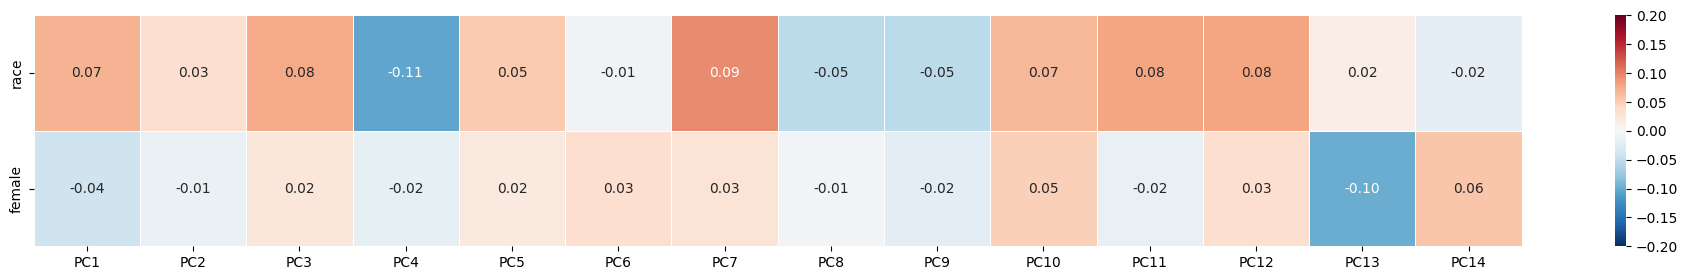

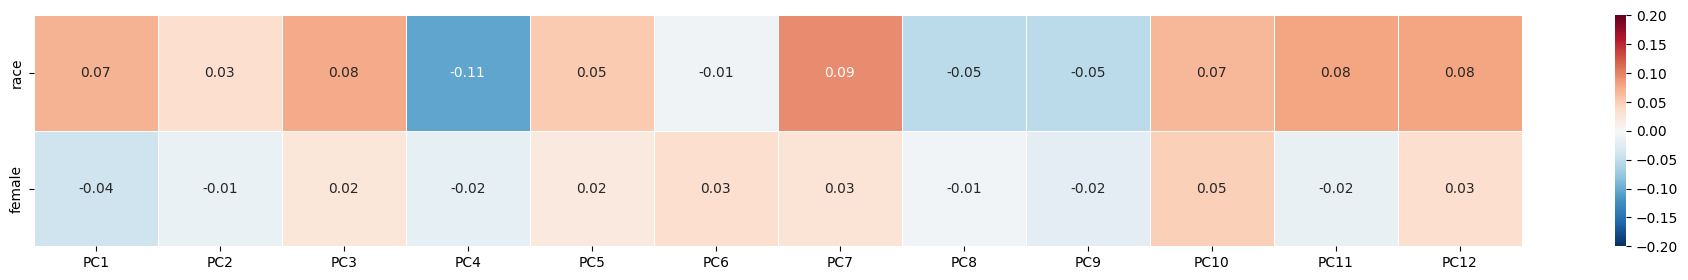

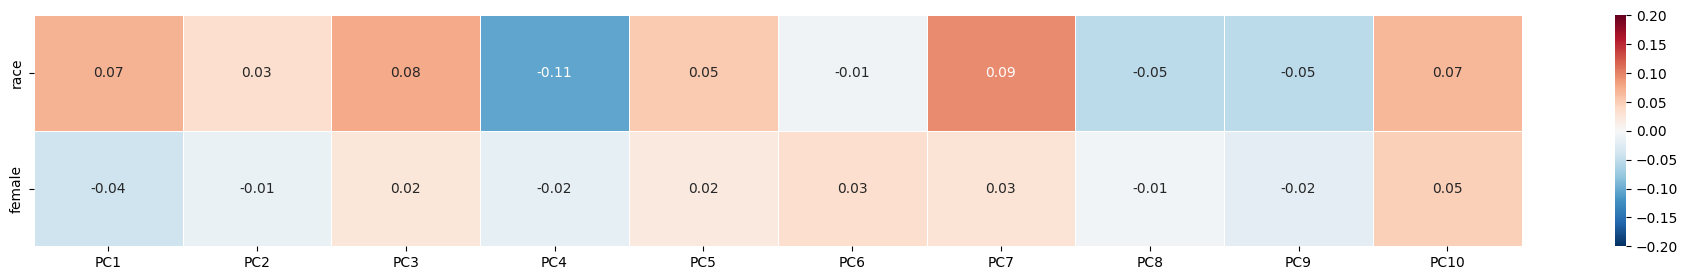

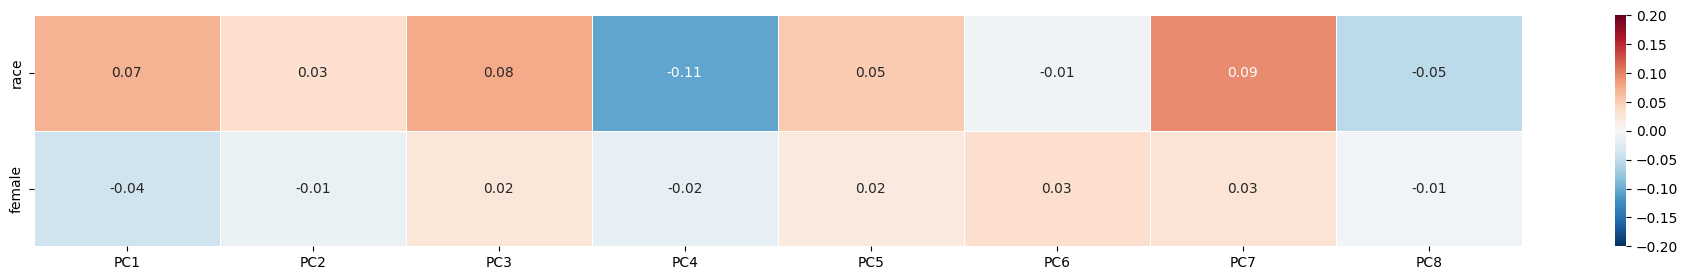

In [57]:
plot_pca_corr(X_pca_14, protected, list(groups))
plot_pca_corr(X_pca_12, protected, list(groups))
plot_pca_corr(X_pca_10, protected, list(groups))
plot_pca_corr(X_pca_8, protected, list(groups))

In [58]:
# normalize column for number of priores
non_protected_features_scaled_test = nonprotected_test.copy()
non_protected_features_scaled_test = scaler.transform(non_protected_features_scaled_test)

reconstruction_error(X_pca_14, pca_14, non_protected_features_scaled_test, protected_test)
print("--------------------------")
reconstruction_error(X_pca_12, pca_12, non_protected_features_scaled_test, protected_test)
print("--------------------------")
reconstruction_error(X_pca_10, pca_10, non_protected_features_scaled_test, protected_test)
print("--------------------------")
reconstruction_error(X_pca_8, pca_8, non_protected_features_scaled_test, protected_test)

1.5131785677863835e-15
1.4848615307794602e-15
1.5746443249550648e-15
1.4921071850659224e-15
--------------------------
0.10153158469634019
0.10158306513922187
0.1215375195052682
0.09966261043927097
--------------------------
0.22812270019721542
0.23188458818848262
0.2643019236447412
0.2267178380058156
--------------------------
0.35135504735551243
0.366538764638069
0.3966841422980426
0.35523148714703634


In [59]:
X_projected_14, Z_14, U_14 = fair_pca(non_protected_features_scaled, protected, 14)
X_projected_12, Z_12, U_12 = fair_pca(non_protected_features_scaled, protected, 12)
X_projected_10, Z_10, U_10 = fair_pca(non_protected_features_scaled, protected, 10)
X_projected_8, Z_8, U_8 = fair_pca(non_protected_features_scaled, protected, 8)

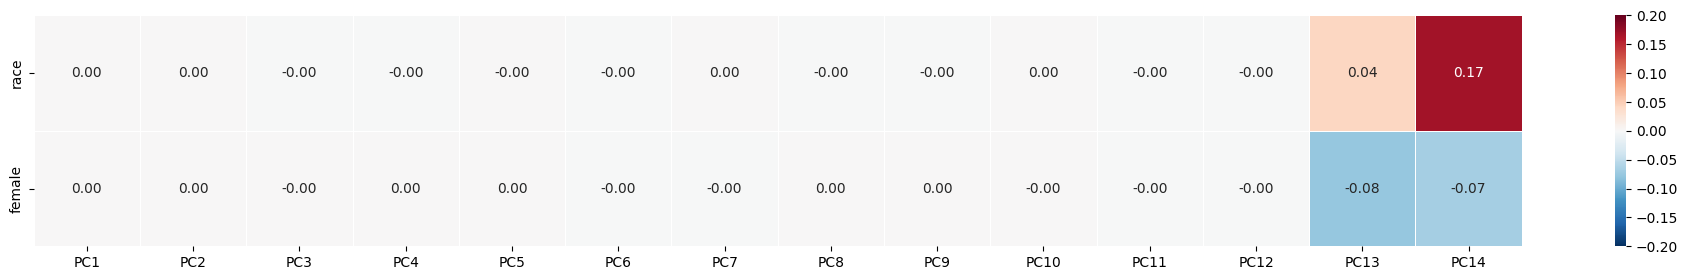

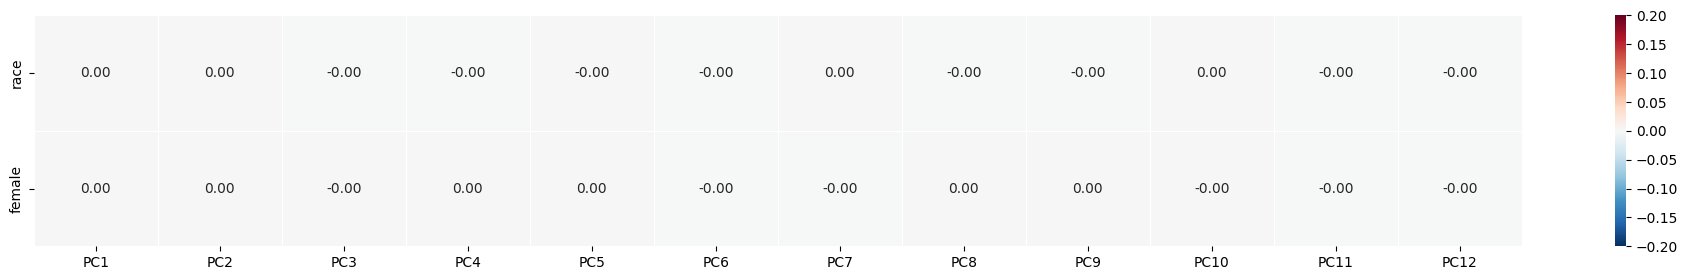

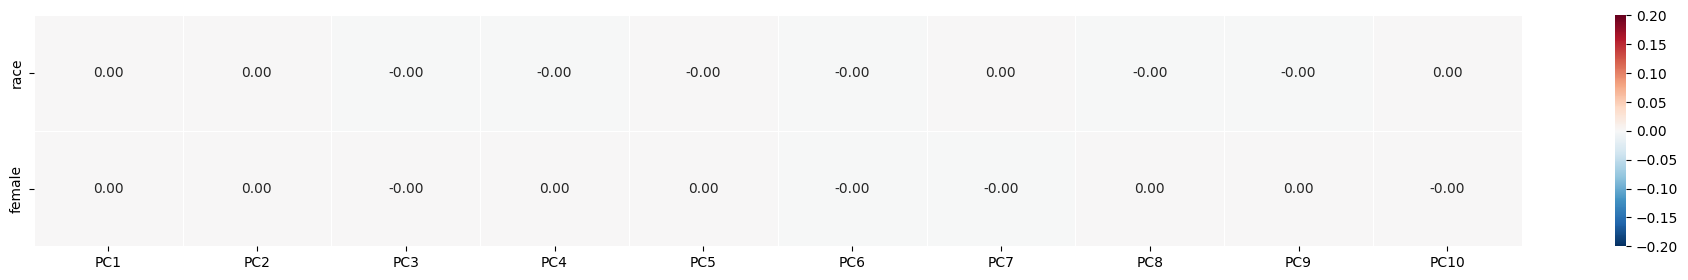

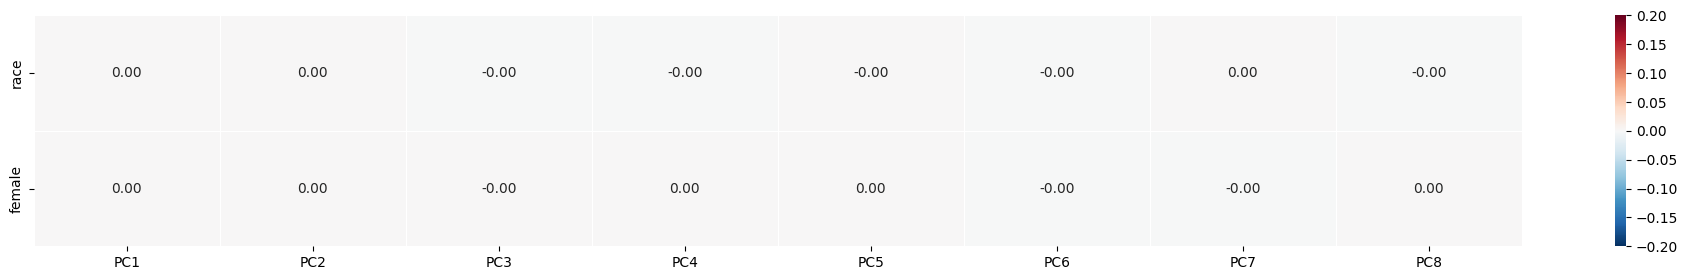

In [60]:
plot_pca_corr(X_projected_14, protected, list(groups))
plot_pca_corr(X_projected_12, protected, list(groups))
plot_pca_corr(X_projected_10, protected, list(groups))
plot_pca_corr(X_projected_8, protected, list(groups))

In [61]:
# project test data
X_test_projected_14 = non_protected_features_scaled_test @ U_14
X_test_projected_12 = non_protected_features_scaled_test @ U_12
X_test_projected_10 = non_protected_features_scaled_test @ U_10
X_test_projected_8 = non_protected_features_scaled_test @ U_8

reconstruction_error_fair_pca(X_projected_14, X_test_projected_14, U_14, non_protected_features_scaled_test, protected_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_12, X_test_projected_12, U_12, non_protected_features_scaled_test, protected_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_10, X_test_projected_10, U_10, non_protected_features_scaled_test, protected_test)
print("----------------------------------")
reconstruction_error_fair_pca(X_projected_8, X_test_projected_8, U_8, non_protected_features_scaled_test, protected_test)

0.26118993892548376
0.2862562145950175
0.29653428121457015
0.27133312000459386
----------------------------------
0.26118993892548376
0.2862562145950175
0.29653428121457015
0.2713331200045939
----------------------------------
0.3369133549023765
0.3497688889512559
0.3592121472510426
0.3417198698354529
----------------------------------
0.429004040006658
0.44478794194164817
0.4544168989798746
0.43509176398161975


Balanced accuracy on test set: 0.6715895788528027
Precision on test set: 0.6671779141104295
Recall on test set: 0.6651376146788991
F1 score on test set: 0.666156202143951


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


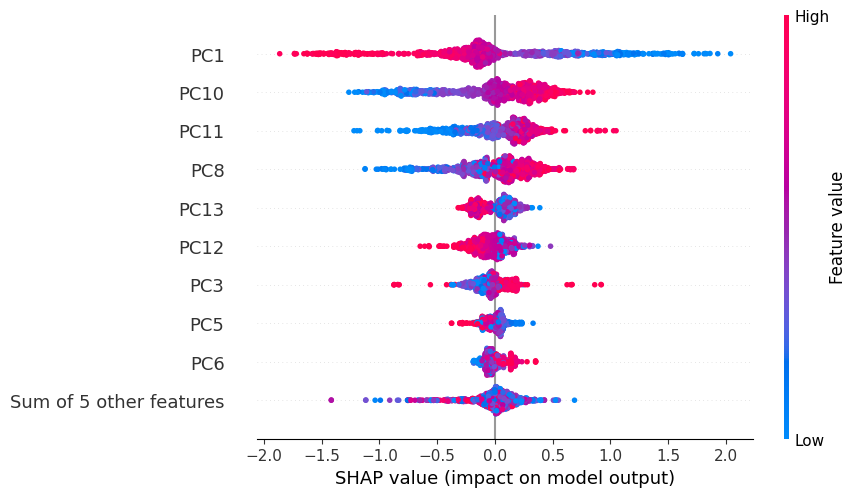

In [62]:
xgb_14 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_14 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_14 = Pipeline([('scaler', scaler_14), ('xgb', xgb_14)])
xgb_pipeline_14.fit(X_projected_14, y_train)
y_pred_xgb_14 = xgb_pipeline_14.predict(X_test_projected_14)
metric_scores = calculate_metrics(y_test, y_pred_xgb_14)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

X_train_14 = xgb_pipeline_14['scaler'].transform(X_projected_14)
X_test_14 = xgb_pipeline_14['scaler'].transform(X_test_projected_14)

# explain the model's predictions using SHAP
explainer_14 = shap.Explainer(xgb_pipeline_14['xgb'], X_train_14, feature_names=[f"PC{i}" for i in range(1, len(X_train_14[0])+1)])
shap_values_14 = explainer_14(X_test_14)
shap.plots.beeswarm(shap_values_14, max_display=10)

Balanced accuracy on test set: 0.6699924681712175
Precision on test set: 0.6677018633540373
Recall on test set: 0.6574923547400612
F1 score on test set: 0.6625577812018489


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


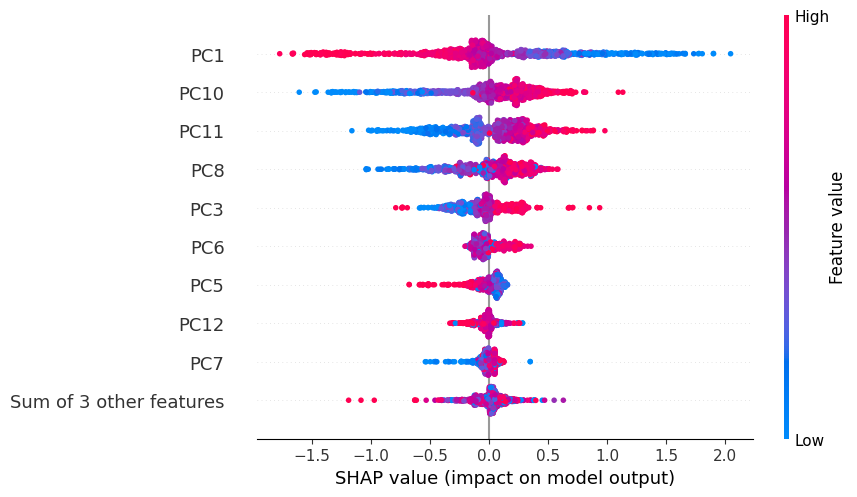

In [63]:
xgb_12 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_12 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_12 = Pipeline([('scaler', scaler_12), ('xgb', xgb_12)])
xgb_pipeline_12.fit(X_projected_12, y_train)
y_pred_xgb_12 = xgb_pipeline_12.predict(X_test_projected_12)
metric_scores = calculate_metrics(y_test, y_pred_xgb_12)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

X_train_12 = xgb_pipeline_12['scaler'].transform(X_projected_12)
X_test_12 = xgb_pipeline_12['scaler'].transform(X_test_projected_12)

# explain the model's predictions using SHAP
explainer_12 = shap.Explainer(xgb_pipeline_12['xgb'], X_train_12, feature_names=[f"PC{i}" for i in range(1, len(X_train_12[0])+1)])
shap_values_12 = explainer_12(X_test_12)
shap.plots.beeswarm(shap_values_12, max_display=10)

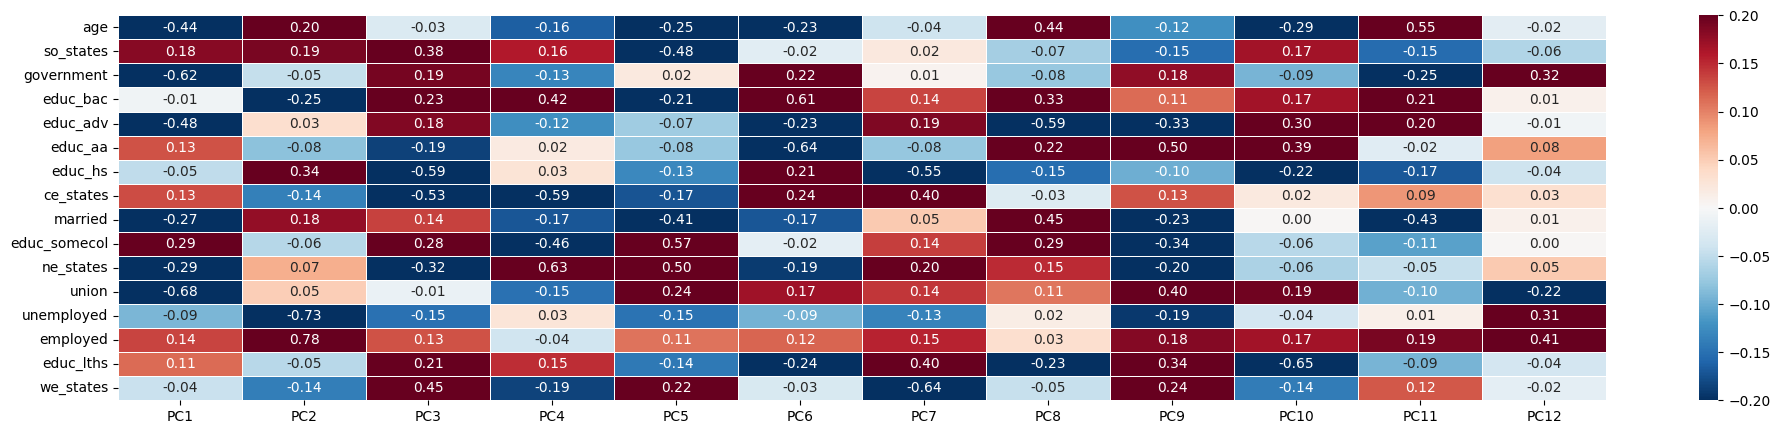

In [64]:
# calculate the correlation between the principal components and the attributes
plot_pca_corr(X_projected_12, nonprotected, list(features.columns[:-2]), (24,5))

Balanced accuracy on test set: 0.6683726712583599
Precision on test set: 0.668769716088328
Recall on test set: 0.6483180428134556
F1 score on test set: 0.6583850931677019


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


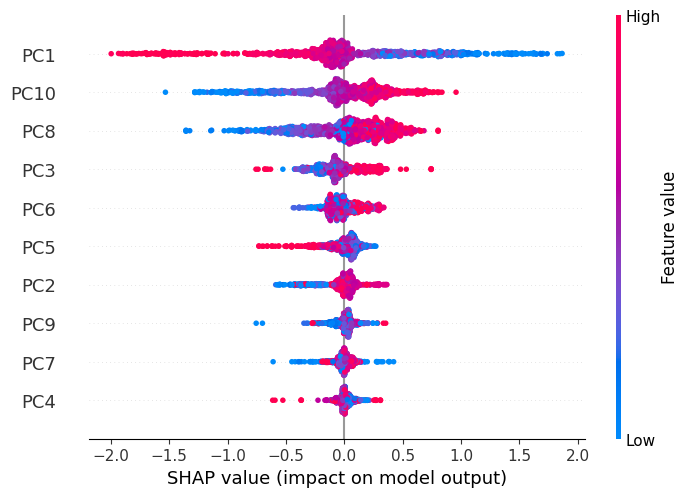

In [65]:
xgb_10 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_10 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_10 = Pipeline([('scaler', scaler_10), ('xgb', xgb_10)])
xgb_pipeline_10.fit(X_projected_10, y_train)
y_pred_xgb_10 = xgb_pipeline_10.predict(X_test_projected_10)
metric_scores = calculate_metrics(y_test, y_pred_xgb_10)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

X_train_10 = xgb_pipeline_10['scaler'].transform(X_projected_10)
X_test_10 = xgb_pipeline_10['scaler'].transform(X_test_projected_10)

# explain the model's predictions using SHAP
explainer_10 = shap.Explainer(xgb_pipeline_10['xgb'], X_train_10, feature_names=[f"PC{i}" for i in range(1, len(X_train_10[0])+1)])
shap_values_10 = explainer_10(X_test_10)
shap.plots.beeswarm(shap_values_10, max_display=10)

Balanced accuracy on test set: 0.6655187433642773
Precision on test set: 0.6620370370370371
Recall on test set: 0.6559633027522935
F1 score on test set: 0.6589861751152074


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


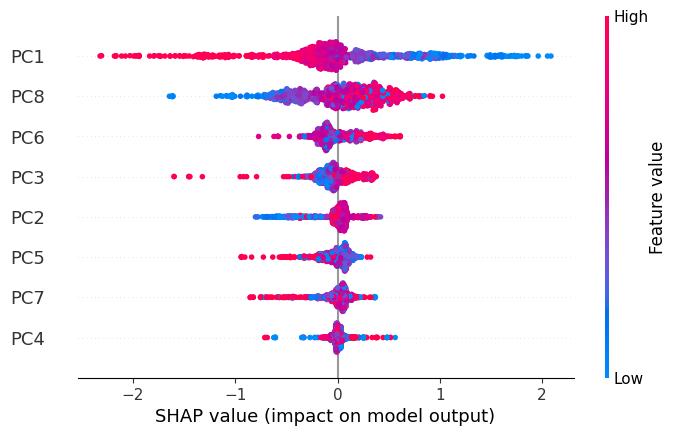

In [66]:
xgb_8 = xgboost.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
scaler_8 = ColumnTransformer([('scaler', MinMaxScaler(), slice(0, 1))], remainder='passthrough') # scale only the first column (Number_of_Priors), leave the remainder untouched
xgb_pipeline_8 = Pipeline([('scaler', scaler_8), ('xgb', xgb_8)])
xgb_pipeline_8.fit(X_projected_8, y_train)
y_pred_xgb_8 = xgb_pipeline_8.predict(X_test_projected_8)
metric_scores = calculate_metrics(y_test, y_pred_xgb_8)
print("Balanced accuracy on test set:", metric_scores['accuracy'])
print("Precision on test set:", metric_scores['precision'])
print("Recall on test set:", metric_scores['recall'])
print("F1 score on test set:", metric_scores['f1_score'])

X_train_8 = xgb_pipeline_8['scaler'].transform(X_projected_8)
X_test_8 = xgb_pipeline_8['scaler'].transform(X_test_projected_8)

# explain the model's predictions using SHAP
explainer_8 = shap.Explainer(xgb_pipeline_8['xgb'], X_train_8, feature_names=[f"PC{i}" for i in range(1, len(X_train_8[0])+1)])
shap_values_8 = explainer_8(X_test_8)
shap.plots.beeswarm(shap_values_8, max_display=10)

In [67]:
calc_certainty(y_test, y_pred_xgb_12)

Confidence interval for the f1_score [0.95]:[0.633 - 0.692]


In [72]:
equalized_odds_gender = flm.demographic_parity_ratio(y_test, y_pred_xgb_12, sensitive_features=group_test["female"])
equalized_odds_race = flm.demographic_parity_ratio(y_test, y_pred_xgb_12, sensitive_features=group_test["race"])

In [73]:
print(equalized_odds_race)
print(equalized_odds_gender)

0.8113712374581941
0.9147991496027751


In [54]:
# calculate fairness metrics and accuracy scores
# calculate fairness metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
fairness_metrics_14 = calculate_fairness_metrics(y_test, y_pred_xgb_14, group_test)
for key, value in fairness_metrics_14.items():
    print(key, ":",  value)
print("----------------------------------")
fairness_metrics_12 = calculate_fairness_metrics(y_test, y_pred_xgb_12, group_test)
for key, value in fairness_metrics_12.items():
    print(key, ":",  value)
print("----------------------------------")
fairness_metrics_10 = calculate_fairness_metrics(y_test, y_pred_xgb_10, group_test)
for key, value in fairness_metrics_10.items():
    print(key, ":",  value)
print("----------------------------------")
fairness_metrics_8 = calculate_fairness_metrics(y_test, y_pred_xgb_8, group_test)
for key, value in fairness_metrics_8.items():
    print(key, ":",  value)

race : {'equalized_odds_tpr': 0.041263305444828924, 'equalized_odds_fpr': 0.07352435036998797, 'equalized_odds': 0.041263305444828924, 0: {'tpr': 0.6628849270664505, 'fpr': 0.31711409395973156, 'fnr': 0.3371150729335494, 'tnr': 0.6828859060402684}, 1: {'tpr': 0.6216216216216216, 'fpr': 0.24358974358974358, 'fnr': 0.3783783783783784, 'tnr': 0.7564102564102564}}
female : {'equalized_odds_tpr': 0.020657651813781763, 'equalized_odds_fpr': 0.09828440716736564, 'equalized_odds': 0.020657651813781763, 0: {'tpr': 0.6528117359413202, 'fpr': 0.2459016393442623, 'fnr': 0.3471882640586797, 'tnr': 0.7540983606557377}, 1: {'tpr': 0.673469387755102, 'fpr': 0.34418604651162793, 'fnr': 0.32653061224489793, 'tnr': 0.6558139534883721}}
----------------------------------
race : {'equalized_odds_tpr': 0.038021814358929484, 'equalized_odds_fpr': 0.02559800378592325, 'equalized_odds': 0.02559800378592325, 0: {'tpr': 0.6596434359805511, 'fpr': 0.32046979865771813, 'fnr': 0.34035656401944897, 'tnr': 0.67953020